# Dropout Prediction EDA

This document contains the EDA of the student dropout dataset. The main method for achieving this task is by using Python data processing libraries with various data visualization packages (e.g. Altair, Matplotlib, etc.) The EDA report will include data splitting, correlation analysis, and serval sections investigating different types of features.

## 0. Project setup

In [1]:
import pandas as pd
import numpy as np
from hashlib import sha1
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

from sklearn.model_selection import train_test_split

# Handle large data sets by not embedding them in the notebook
alt.data_transformers.enable('data_server')

# Save a PNG blob as a backup for when the Altair plots do not render
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## 1. General Exploration

In [2]:
data_path = '../data/raw/data.csv'
sep = ';'

In [3]:
df = pd.read_csv(data_path, sep=sep)
df = df.rename(columns={'Nacionality': 'Nationality', 'Daytime/evening attendance\t': 'Daytime_evening_attendance'})
df.shape

(4424, 37)

### 1.0 Data Splitting

- 80% Training
- 20% Testing

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=522)
df = train_df

### 1.1 Data Exploration

In [5]:
df.head().style.set_caption("<h4 align='left'><b>Table 1. First 5 rows of the dataset<b></h4>")

,Marital status,Application mode,Application order,Course,Daytime_evening_attendance,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
1350,1,1,1,171,1,1,142.000000,1,1,1,3,3,133.300000,1,0,0,1,0,0,19,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.800000,1.400000,1.740000,Graduate
2351,1,44,1,9130,1,39,150.000000,1,2,1,3,6,150.000000,1,0,0,1,1,0,22,0,11,18,32,12,12.857143,1,8,12,15,10,14.300000,0,16.200000,0.300000,-0.920000,Graduate
3946,1,17,2,171,1,1,142.000000,1,3,1,2,6,139.400000,1,0,0,1,0,1,18,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,15.500000,2.800000,-4.060000,Graduate
1265,1,1,6,9500,1,1,137.000000,1,1,1,4,5,126.300000,1,0,0,1,0,1,18,0,0,8,8,8,13.423750,0,0,8,8,8,13.423750,0,9.400000,-0.800000,-3.120000,Graduate
2871,2,39,1,9500,1,1,110.000000,1,37,37,9,6,114.300000,0,0,0,1,0,0,41,0,0,7,0,0,0.000000,0,0,8,0,0,0.000000,0,10.800000,1.400000,1.740000,Dropout


In [6]:
df.tail().style.set_caption("<h4 align='left'><b>Table 2. Last 5 rows of the dataset</b></h4>")

,Marital status,Application mode,Application order,Course,Daytime_evening_attendance,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
3956,1,1,3,9147,1,1,133.000000,1,38,19,9,10,125.000000,1,0,0,1,0,0,18,0,0,5,6,5,12.800000,1,0,5,6,5,12.600000,0,9.400000,-0.800000,-3.120000,Graduate
154,1,43,1,9853,1,1,115.000000,1,3,37,2,5,108.700000,1,0,0,1,0,0,21,0,0,6,10,3,12.666667,0,0,6,12,3,10.000000,0,9.400000,-0.800000,-3.120000,Dropout
3360,1,17,4,9670,1,1,126.000000,1,1,1,4,7,115.200000,0,0,0,0,0,0,19,0,0,6,7,3,12.666667,0,0,6,10,5,13.125000,0,10.800000,1.400000,1.740000,Dropout
1899,1,53,1,9085,1,42,150.000000,1,3,1,2,8,153.800000,1,0,0,1,0,0,21,0,7,11,15,10,14.500000,0,4,9,15,8,14.000000,0,8.900000,1.400000,3.510000,Graduate
3988,1,1,1,9085,1,1,123.000000,1,19,37,9,9,124.100000,1,0,0,1,0,1,20,0,0,5,13,5,14.000000,2,0,5,10,3,12.000000,1,9.400000,-0.800000,-3.120000,Graduate


In [7]:
df = df.dropna()
df.shape

(3539, 37)

The training data-set consists of 3539 records with 36 attributes and contains no missing values. The distribution and statistics are above and below.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3539 entries, 1350 to 3988
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  3539 non-null   int64  
 1   Application mode                                3539 non-null   int64  
 2   Application order                               3539 non-null   int64  
 3   Course                                          3539 non-null   int64  
 4   Daytime_evening_attendance                      3539 non-null   int64  
 5   Previous qualification                          3539 non-null   int64  
 6   Previous qualification (grade)                  3539 non-null   float64
 7   Nationality                                     3539 non-null   int64  
 8   Mother's qualification                          3539 non-null   int64  
 9   Father's qualification                

All of our features are either integers or float, and most of the integer variables are categorical features. The class label is also a categorical variable with 3 classes (Graduate, Dropout, Enrolled).

C:\Users\caesa_mt2kv9g\.conda\envs\dropout_pred_env\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


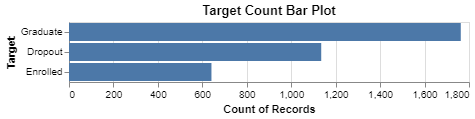

In [9]:
target_bar = alt.Chart(df,
                     title='Target Count Bar Plot'
         ).mark_bar().encode(
                x='count(Target)',
                y=alt.Y('Target', sort='-x'),
)
target_bar

**Fig 1. Target Count Bar Plot**

In [10]:
df.Target.value_counts(normalize=True)

Graduate    0.498163
Dropout     0.320712
Enrolled    0.181125
Name: Target, dtype: float64

From the above plot, we can see this problem was a three-category classification task, and there exists a strong imbalance between those three classes. The class Graduate has the majority count which is around 50% of the records and Dropout has 32% of the total records. The Enrolled only has 18% of the total records. Thus, during our training, we need to find a way to fix this imbalance issue, possible solution would be setting the `class_weight` in our model.

### 1.2 Dropping Enrolled Student

In [11]:
df = df.drop(df[df.Target == 'Enrolled'].index)
df.shape

(2898, 37)

In [12]:
df.Target.value_counts(normalize=True)

Graduate    0.608351
Dropout     0.391649
Name: Target, dtype: float64

After dropping the Enrolled students, we have around 60% graduated students and 40% dropout students.

### 1.3 Rearranging Column Order By Potential Category

In [13]:
df = df[['Marital status', 'Nationality','Displaced','Gender',
                'Age at enrollment', 'International',
                "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation",
                
       'Educational special needs', 'Debtor',
       'Tuition fees up to date',  'Scholarship holder',
        'Unemployment rate','Inflation rate', 'GDP',
                
        'Application mode', 'Application order', 'Course',
                
       'Daytime_evening_attendance', 'Previous qualification',
       'Previous qualification (grade)', 
       'Admission grade',
        
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Target']]

## 2. Feature Correlation

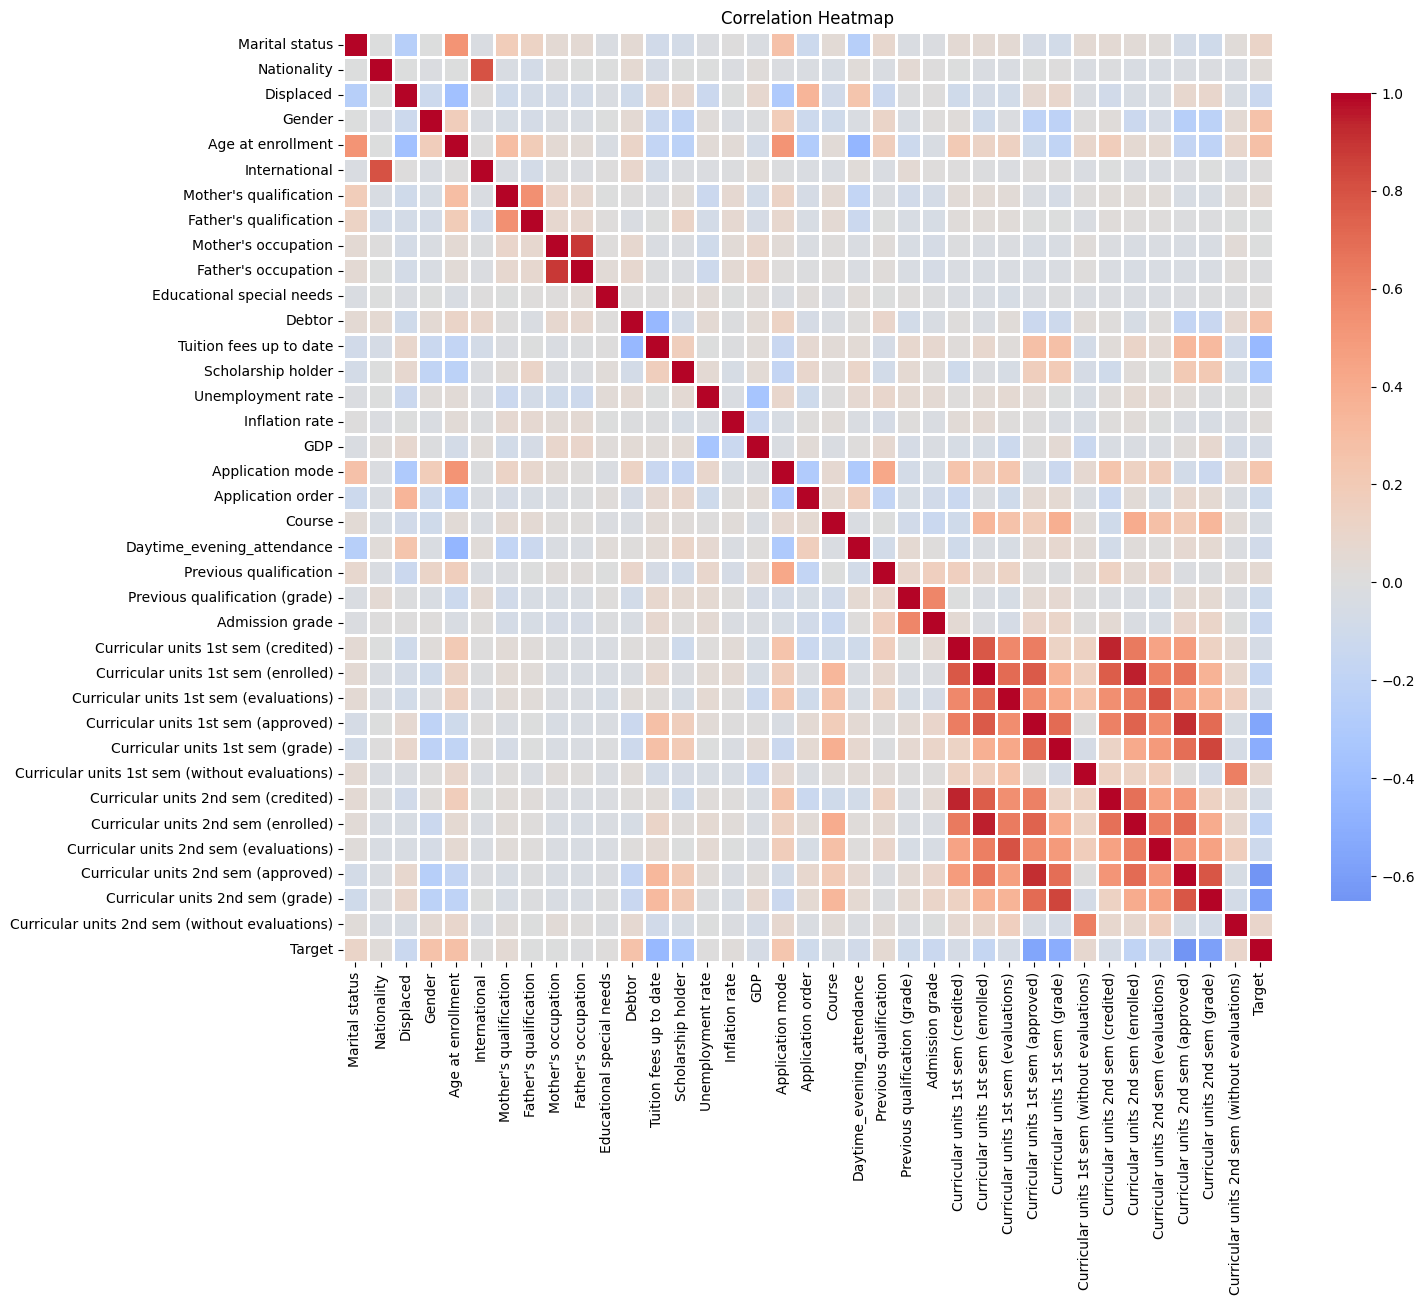

In [14]:
df_target = df.replace({'Target': {'Dropout': 1, 'Graduate': 0}})

f = plt.figure(figsize=(15, 15))
sns.heatmap(df_target.corr(),annot=False, cmap='coolwarm',center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .7})
plt.title('Correlation Heatmap')
plt.show()

**Fig 2. Correlation Heatmap**

From the correlation heatmap, we can observe that some features are strongly correlated (the dark red color), for example, Nationality & International, Age at enrollment & Application mode. There are some features with negative correlation, for example, Age at enrollment & Daytime Evening Attendance. In the following sections, we would like to further investigate those positively correlated features, and features in different potential categories (Demographic, Macroeconomic, Academic data at enrollment, etc.).

Text(0, 0.5, 'Feature Names')

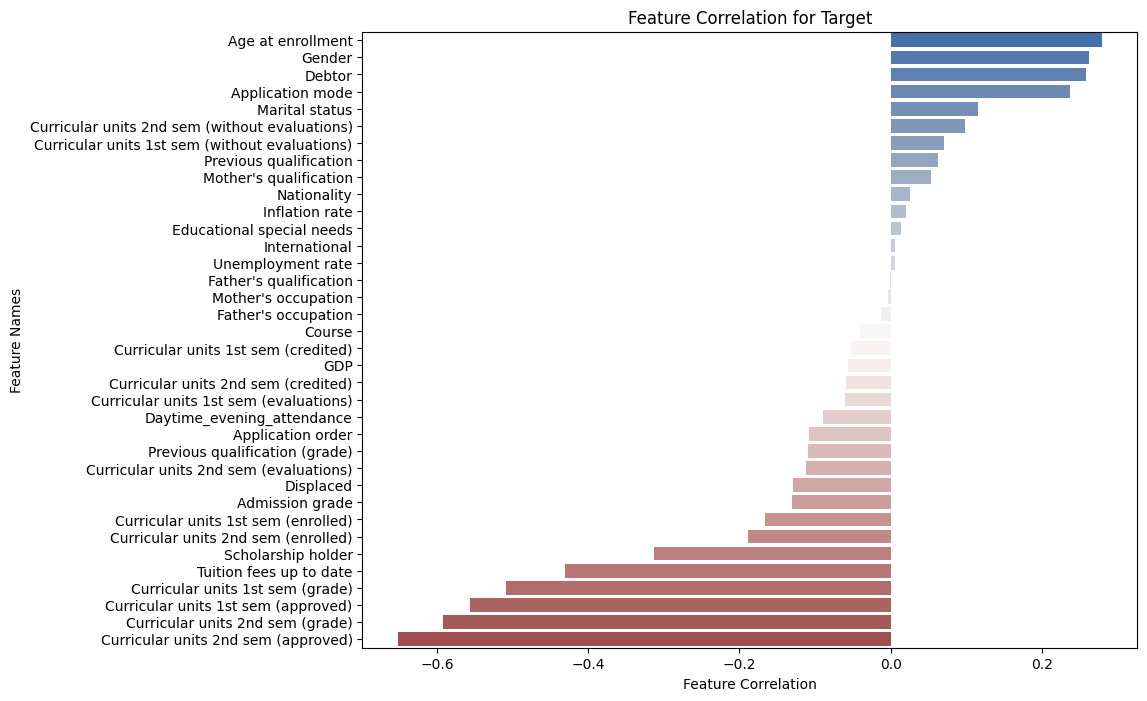

In [15]:
feat_corr = df_target.drop("Target", axis=1).apply(lambda x: x.corr(df_target.Target))
feat_corr = pd.DataFrame(feat_corr, columns=['correlation']).sort_values(['correlation'], ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x=feat_corr['correlation'], y=feat_corr.index, palette="vlag")
plt.title('Feature Correlation for Target')
plt.xlabel('Feature Correlation')
plt.ylabel('Feature Names')

**Fig 3. Feature Correlation for Target**

There are more negatively correlated features than positives one. The top 3 positively correlated features are `Age at enrollment`, `Debtor`, and `Gender`. In the below data exploration, we can further investigate their relationship.

## 3. Numeric / Categorical Feature Overview

### 3.1 Bar Plot on Continuous Features

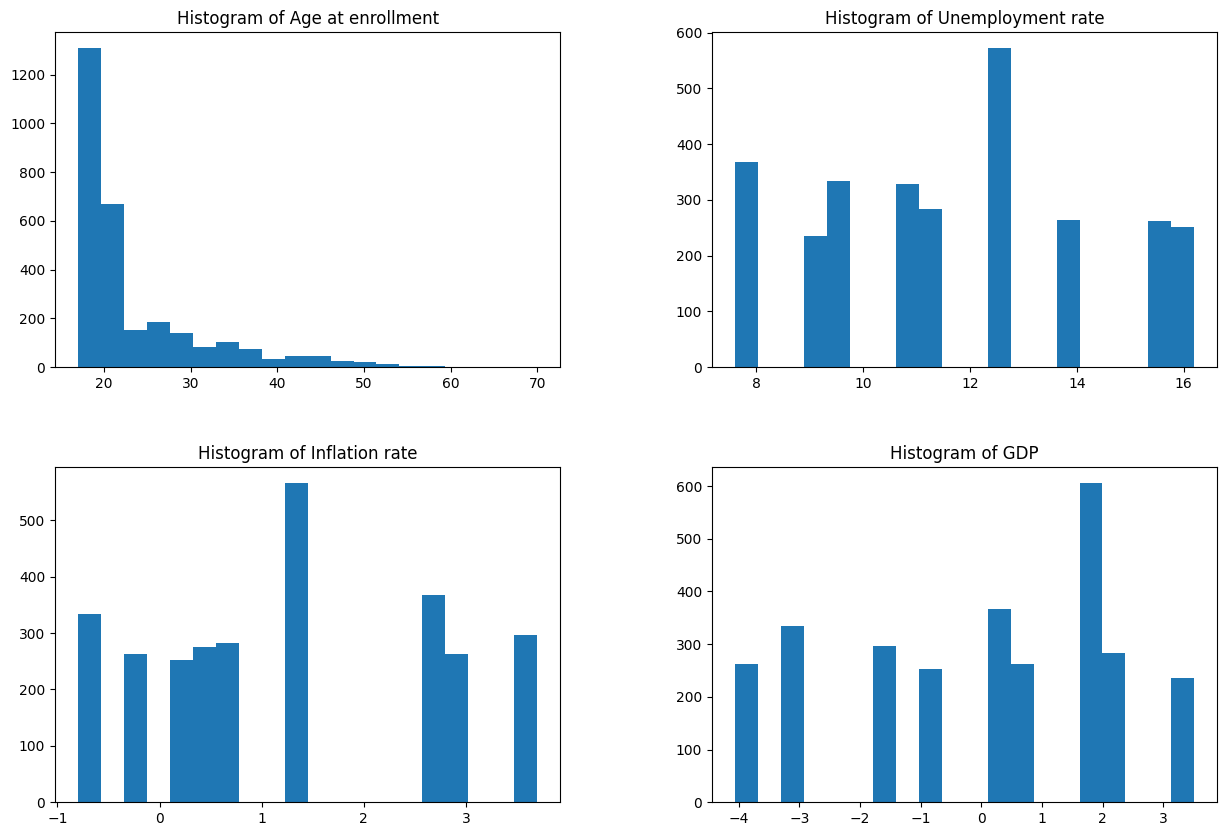

In [16]:
numeric_cols = ['Age at enrollment',
                'Unemployment rate','Inflation rate', 'GDP' 
        ]

fig, axs = plt.subplots(2,2, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)

axs = axs.ravel()

for i in range(0, len(numeric_cols)):

    axs[i].hist(df[numeric_cols[i]], bins=20)
    axs[i].set_title("Histogram of " + numeric_cols[i])

**Fig 4. Histogram for Continuous Features**

From the above bar plot, most of the students enrolled in the program during their 20s. In terms of macroeconomic features, the unemployment rate, inflation rate, and GDP are distributed among different values.

### 3.2 Pair Plot on Continuous Features

Text(0.5, 1.02, 'Pair Plot on Age at enrollment & Macroeconomic Features by Target')

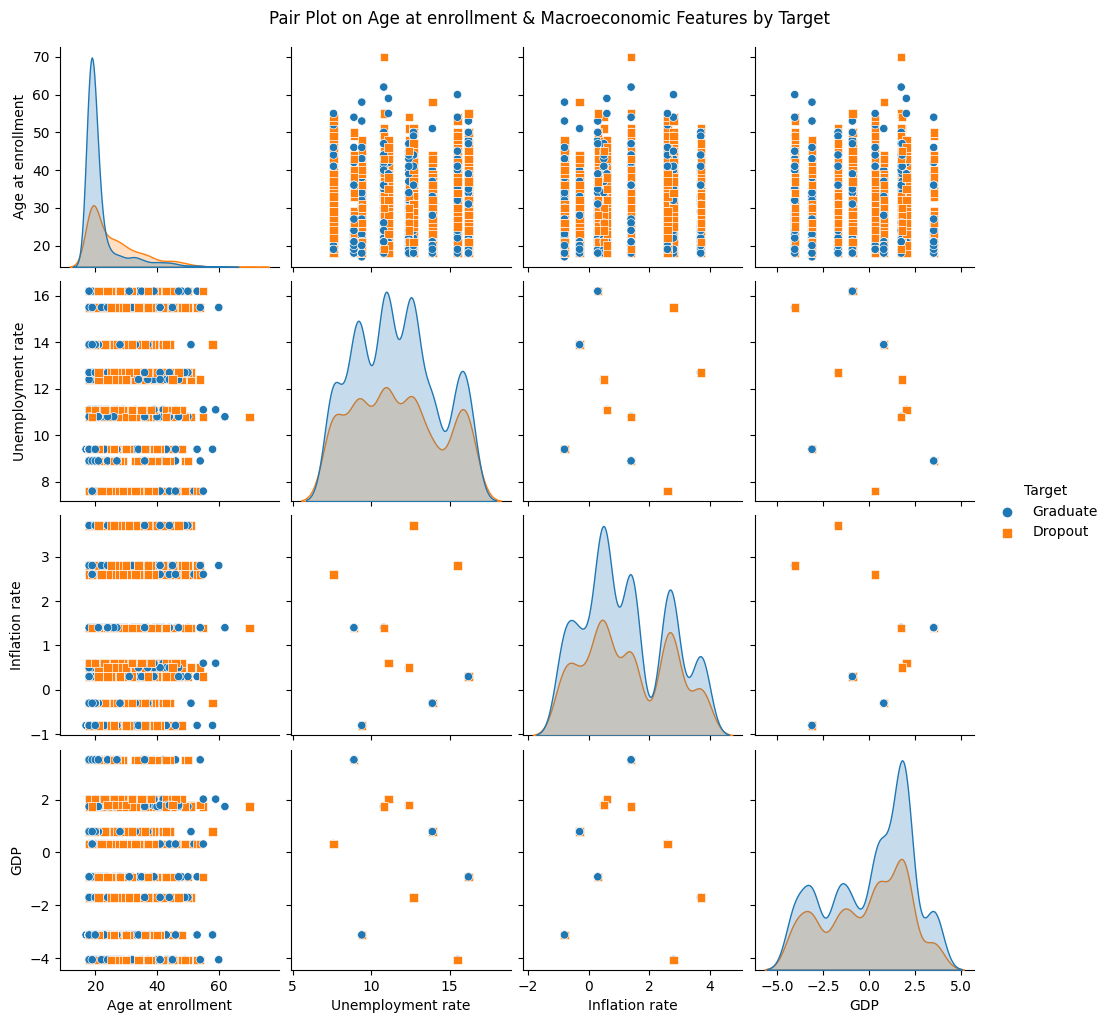

In [17]:
sns_pair = sns.pairplot(df[['Age at enrollment','Unemployment rate',
                 'Inflation rate', 'GDP', 'Target']],
            hue='Target', markers=["o", "s"])
sns_pair.fig.suptitle("Pair Plot on Age at enrollment & Macroeconomic Features by Target", y=1.02)


**Fig 5. Pair Plot on Age at enrollment & Macroeconomic Features by Target**

In the previous section, we examine the continuous features in the bar plot. We would like to further investigate their relationship with the target. For students in their 20s, there is more student graduating. However, there are more students to drop out in their 30s and older. The possible reason could be a student entering the workforce when they are older. In terms of the macroeconomic features, both dropout & graduate students are distributed similarly. There is no linear relationship between each pair of macroeconomic variables, as both classes are not linearly separated in the scatter plot.

### 3.3 Scatter Plot on Student Performance by Target

C:\Users\caesa_mt2kv9g\.conda\envs\dropout_pred_env\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


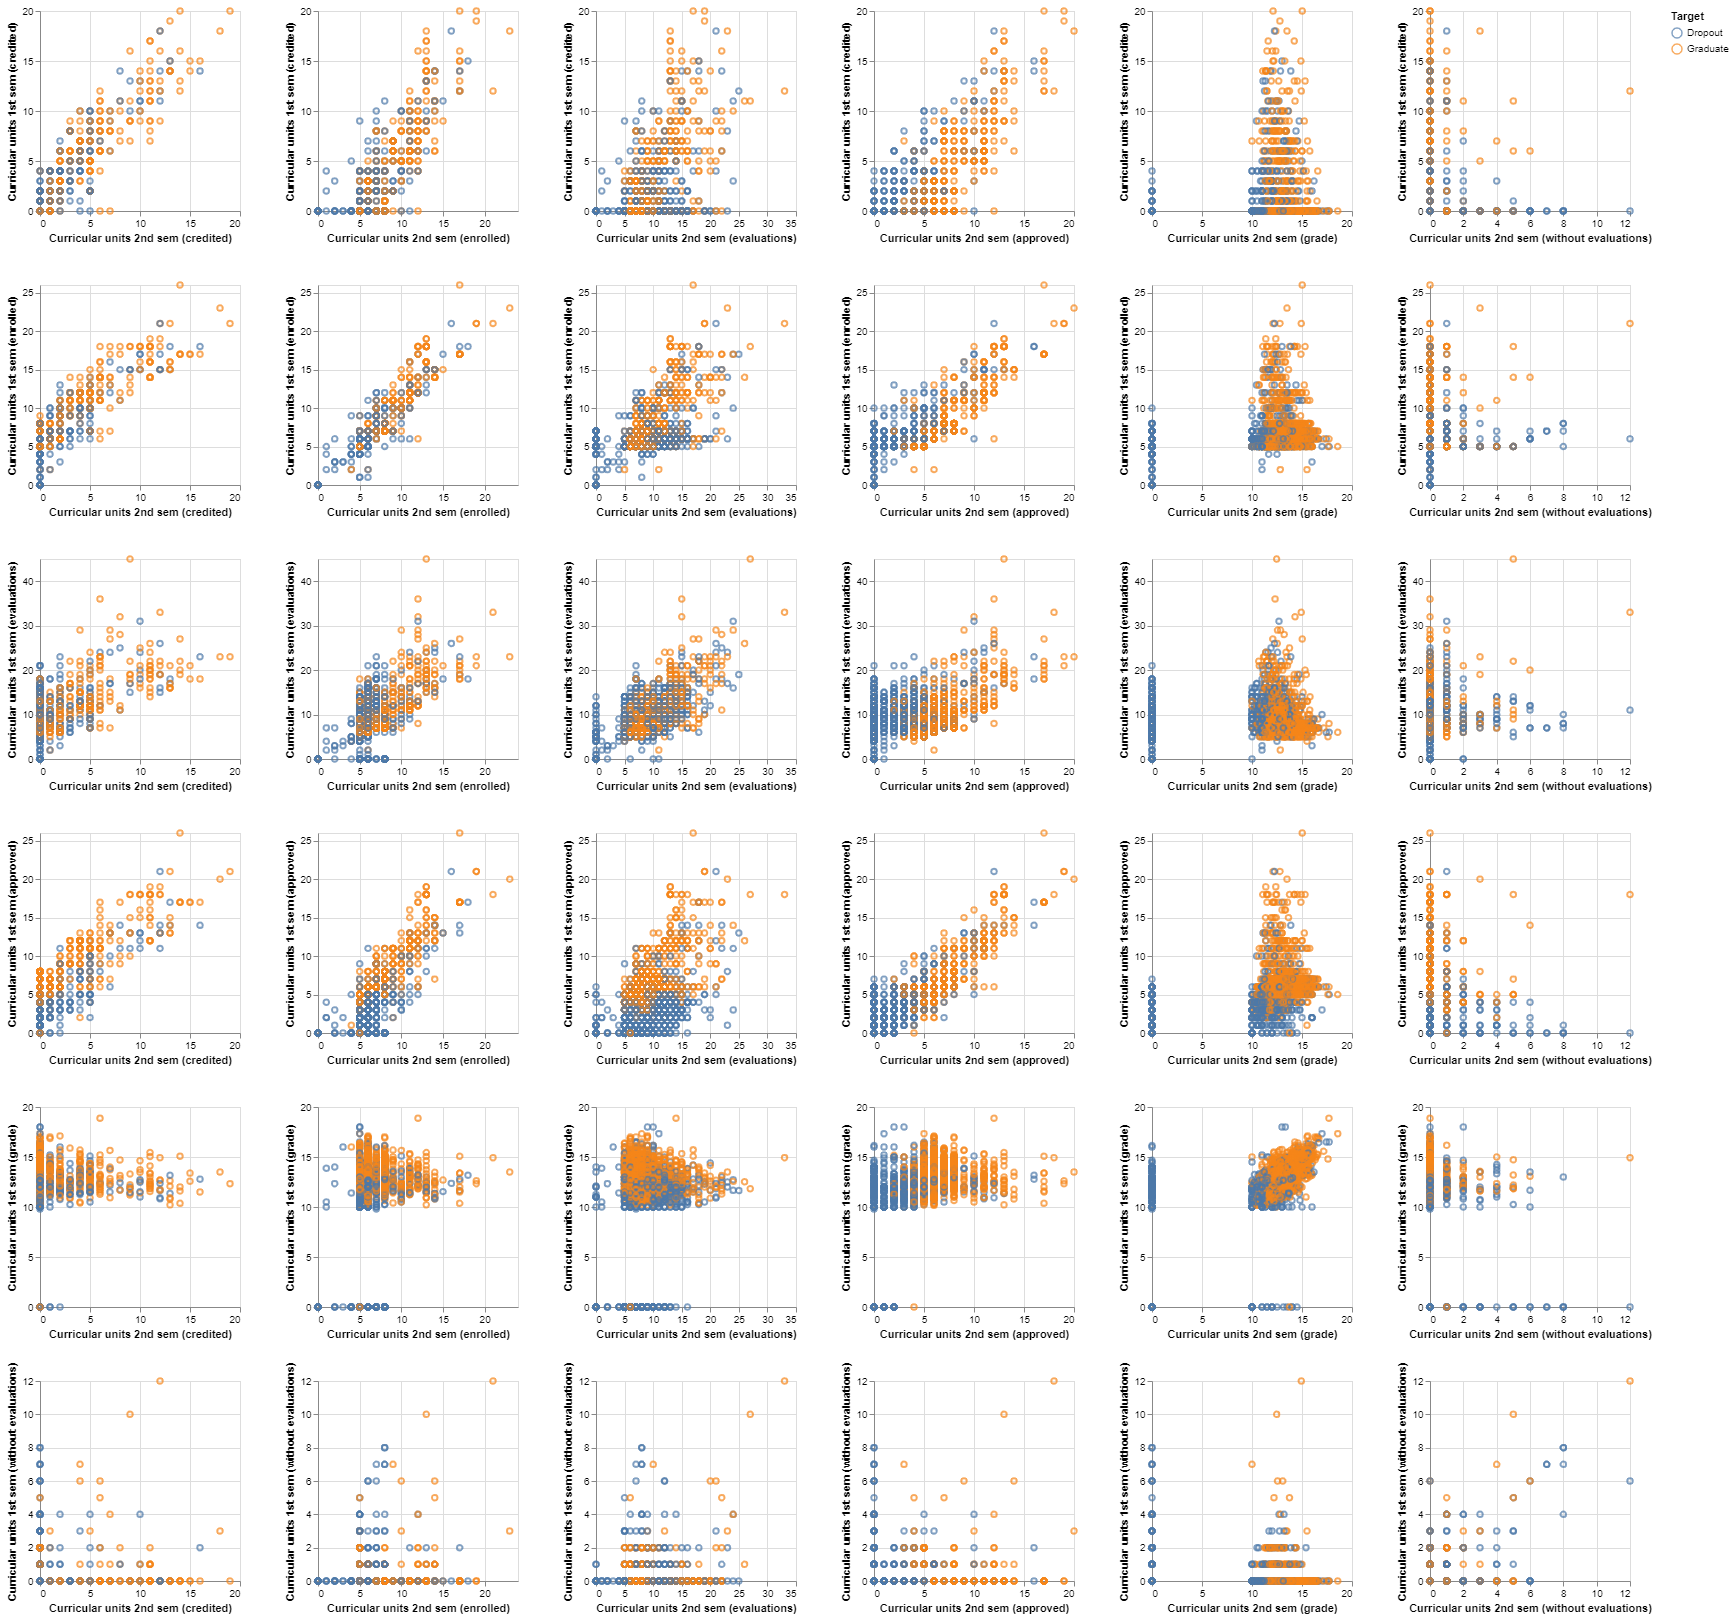

In [18]:
numeric_cols = df.select_dtypes('number').columns.tolist()
numeric_cols

# performance of two semester vs Target
df_new = df[['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 
             'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 
             'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 
             'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 
             'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 
             'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 
             'Target']]

first_sem = ['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 
             'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 
             'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)']

second_sem = ['Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 
              'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 
              'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)']

plot = alt.Chart(df_new).mark_point().encode(
     alt.X(alt.repeat('column'), type='quantitative'),
     alt.Y(alt.repeat('row'), type='quantitative'),
     color = 'Target'
).properties(
    width=200,
    height=200
).repeat(
    row = first_sem,
    column = second_sem
)

plot

**Fig 6. Scatter Plot for Student Performance Features**

Similarly, in student performance, no linear relationship was found among both classes.

## 4. Macroeconomic Features

- `Unemployment rate`
- `Inflation rate`
- `GDP`

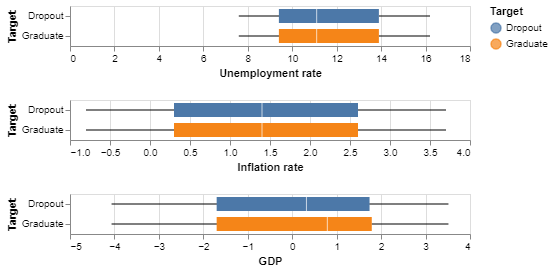

In [19]:
macroeconomic_col = ['Unemployment rate','Inflation rate', 'GDP']
  
macroeconomic_boxplot = alt.Chart(df).mark_boxplot().encode(
    x=alt.X(alt.repeat(), type='quantitative'),
    y='Target',
    color='Target'
).repeat(repeat=macroeconomic_col, columns=1)


macroeconomic_boxplot

**Fig 7. Macroeconomic Features Boxplot**

In general, the macroeconomic features show a similar trend for each class in terms of their range and quantile. Both classes tend to have identical distributions as we observed in the pair plot.

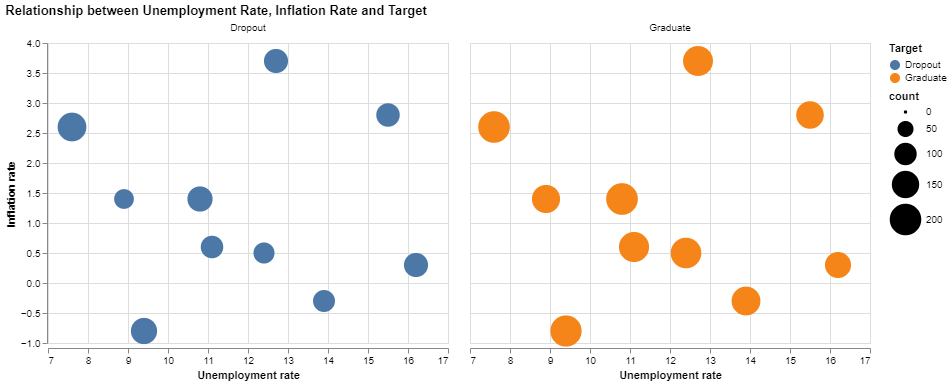

In [20]:
# sns.scatterplot(x='Unemployment rate', y='Inflation rate', hue="Target", data=df)
# plt.title("Relationship between Unemployment Rate, Inflation Rate and target")
# plt.show()

macroeconomic_scatter = alt.Chart(df,
        ).mark_circle().encode(
    x=alt.X('Unemployment rate', scale=alt.Scale(zero=False)),
    y=alt.Y('Inflation rate', scale=alt.Scale(zero=False)),
    color='Target',
    tooltip=['count()', 'Unemployment rate', 'Inflation rate'],
    size=alt.Size('count()',
                  title='count',  scale=alt.Scale(range=(10, 1000)))
)

macroeconomic_scatter = alt.layer(macroeconomic_scatter).facet(
    facet=alt.Facet('Target', title=None),
    title="Relationship between Unemployment Rate, Inflation Rate and Target"
)

macroeconomic_scatter

**Fig 8. Unemployment Rate & Inflation Rate Scatter Plot**

For both the inflation rate and unemployment rate, dropout & graduate students show the same scatter point position. The only difference is the record count in the rating level. Therefore, these features might not be informative in our modeling.

## 5. Marital Status

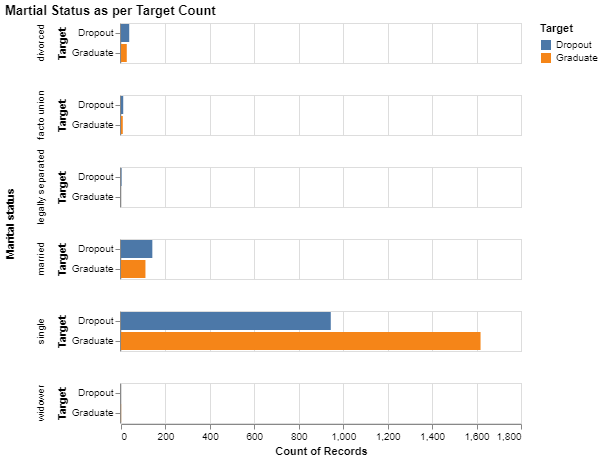

In [21]:
marital_dict = {1: 'single', 2: 'married', 3 : 'widower', 4 : 'divorced', 5 : 'facto union' , 6 : 'legally separated'}
df2=df.replace({"Marital status": marital_dict})

marital_bar = alt.Chart(df2).mark_bar().encode(
    x='count()',
    y='Target',
    color='Target',
    tooltip='count()'
).facet(
    row='Marital status',
    spacing=30,
    title='Martial Status as per Target Count'
)

marital_bar

**Fig 9. Marital Status Bar Plot**

Single student accounts for the majority of the population and tends to graduate from the program. More married or divorced students drop out than graduating, while the other marital status student appears insignificant amount among the group.

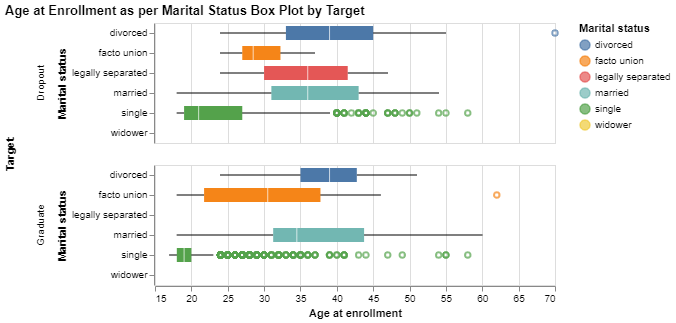

In [22]:
marital_boxplot = alt.Chart(df2).mark_boxplot().encode(
    x=alt.X('Age at enrollment', scale=alt.Scale(zero=False)),
    y='Marital status:N',
    color='Marital status:N'
).facet(
    row='Target',
    title='Age at Enrollment as per Marital Status Box Plot by Target'
)

marital_boxplot

**Fig 10. Age at Enrollment & Marital Status Box Plot by Target**

To better understand the marital status, we could examine the student's ages when they enrolled in the program. Most of the single students are in their 20s with outliers observed after their 30s. Students with a marriage history are mainly distributed in their 30s and above. Since there are too few data points for legally separated and widower students, their box plot is omitted. Overall, the age at enrollment and the student's marital status display a logical relationship in modern society.

## 6. Gender

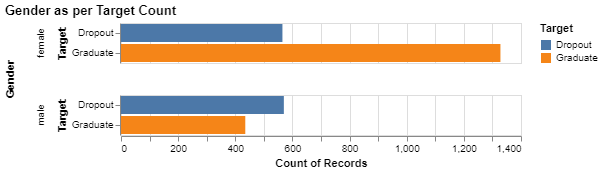

In [23]:
gender_dict = {1: 'male', 0: 'female'}
df2=df2.replace({"Gender": gender_dict})

gender_bar = alt.Chart(df2).mark_bar().encode(
    x='count()',
    y='Target',
    color='Target',
    tooltip='count()'
).facet(
    row='Gender',
    spacing=30,
    title='Gender as per Target Count'
)

gender_bar

**Fig 11. Gender by Target Bar Plot**

Apart from marital status, gender is also one of the important demographic features. In this dataset, there is more female sample than males. More female students tend to graduate than drop out of the program, while male students show the opposite behavior. 

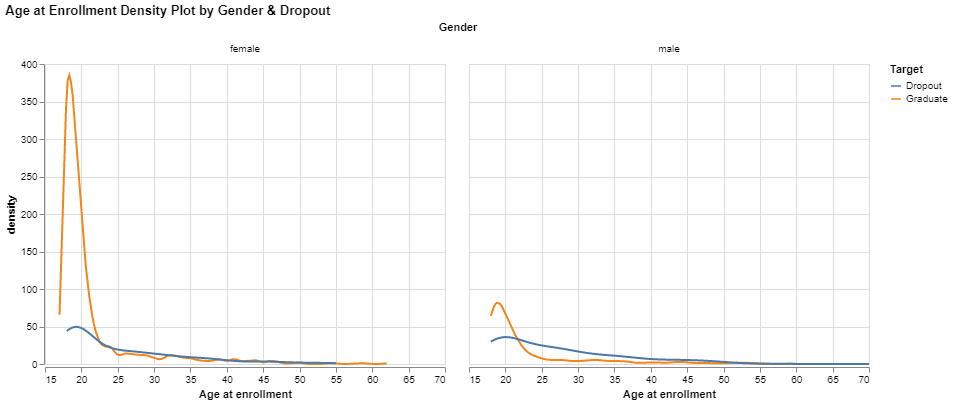

In [24]:
gender_density = (alt.Chart(df2)
 .transform_density(
     'Age at enrollment',
     groupby=['Target','Gender'],
     as_=['Age at enrollment', 'density'],
     counts=True,
 )
 .mark_line().encode(
     x='Age at enrollment',
     y='density:Q',
     color='Target',
 tooltip='Age at enrollment')
 .facet('Gender',
       title="Age at Enrollment Density Plot by Gender & Dropout"
       )
)

gender_density

**Fig 12. Age at Enrollment Density Plot by Target**

The density plot reveals the gender imbalance in our dataset with the number of younger female students than males. More male student aged 25 to 30 tends to drop out than females. While the students after their 30s, both gender demonstrate similar patterns.

## 7. Course & Attendance Mode

- `Course`:
    - 33 - Biofuel Production Technologies 
    - 171 - Animation and Multimedia Design 
    - 8014 - Social Service (`evening` attendance) 
    - 9003 - Agronomy 
    - 9070 - Communication Design 
    - 9085 - Veterinary Nursing 
    - 9119 - Informatics Engineering 
    - 9130 - Equinculture 
    - 9147 - Management 
    - 9238 - Social Service 
    - 9254 - Tourism 
    - 9500 - Nursing 
    - 9556 - Oral Hygiene 
    - 9670 - Advertising and Marketing Management 
    - 9773 - Journalism and Communication 
    - 9853 - Basic Education 
    - 9991 - Management (`evening` attendance)
- `Attendance Mode`: Daytime / Evening (Social Service, Management)

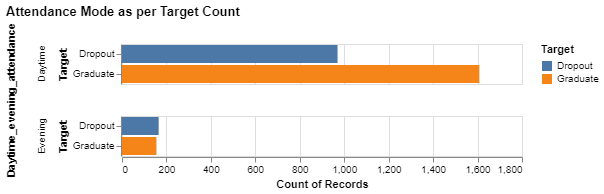

In [25]:
day_evening_dict = {1: 'Daytime', 0: 'Evening'}
df2 = df2.replace({'Daytime_evening_attendance': day_evening_dict})
gender_bar = alt.Chart(df2).mark_bar().encode(
    x='count()',
    y='Target',
    color='Target',
    tooltip='count()'
).facet(
    row="Daytime_evening_attendance",
    spacing=30,
    title='Attendance Mode as per Target Count'
)

gender_bar

**Fig 13. Attendance Bar Plot by Target**

There are only two courses that offer both daytime and evening attendance, which are Social Service and Management. In those daytime courses, more students are graduating than dropping out, while there are an equal amount of students for both classes in the evening class.

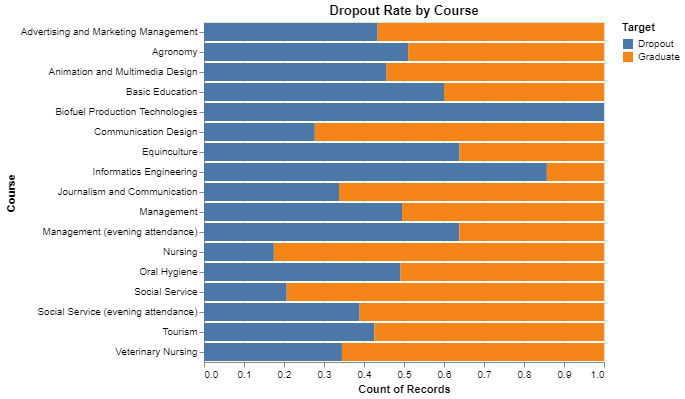

In [26]:
course_dict = {33:"Biofuel Production Technologies",
171:"Animation and Multimedia Design",
8014:"Social Service (evening attendance)",
9003:"Agronomy",
9070:"Communication Design",
9085:"Veterinary Nursing",
9119:"Informatics Engineering",
9130:"Equinculture",
9147:"Management",
9238:"Social Service",
9254:"Tourism",
9500:"Nursing",
9556:"Oral Hygiene",
9670:"Advertising and Marketing Management",
9773:"Journalism and Communication",
9853:"Basic Education",
9991:"Management (evening attendance)"}
df3 = df2.replace({'Course': course_dict})

dropout_bars = alt.Chart(df3, title='Dropout Rate by Course').mark_bar().encode(
    x=alt.X('count()' ,stack="normalize"),
    y='Course',
    color='Target',
    tooltip='count()'
)

dropout_bars

**Fig 14. Course Bar Plot (Normalized) by Target**

The highest 2 dropout courses are Biofuel Production Technologies and Informatics Engineering with more than 80% dropout rate, while Nursing and Social Service (daytime attendance) have the top 2 lowest dropout rate at around 20%. The remaining courses have dropout rate between 30% and 60%. 

## 8. Debtor

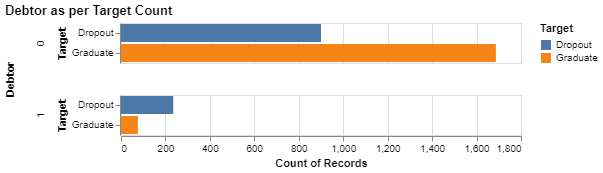

In [27]:
alt.Chart(df2).mark_bar().encode(
    x='count()',
    y='Target',
    color='Target',
    tooltip='count()'
).facet(
    row='Debtor',
    spacing=30,
    title='Debtor as per Target Count'
)

**Fig 15. Debtor Bar Plot by Target**

Most student who owes a debt is likely to drop out of school, while students without debt are likely to graduate with a 66% chance according to the above bar plot.

## Key Takeaways from the EDA

- We will only consider the `Graduate` (60%) and `Dropout` (40%) students in our dataset.
- The top 3 positively correlated features to the `Target` are `Age at enrollment`, `Debtor`, and `Gender`.
- There is no linear relationship between each pair of macroeconomic and academic performance features.
- Graduate and Dropout student shows a similar trend in the macroeconomic features.
- Most students are single and less likely to drop out.
- Gender imbalance found in the dataset, most female students are likely to graduate.
- The highest 2 dropout courses are Biofuel Production Technologies and Informatics Engineering with more than 80% dropout rate.
- Student who owes a debt is likely to drop out of school.

## References

The data is downloaded from the [UCI Database](https://archive-beta.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) under the title `Predict students' dropout and academic success`

- Realinho,Valentim, Vieira Martins,Mónica, Machado,Jorge & Baptista,Luís. (2021). Predict students' dropout and academic success. UCI Machine Learning Repository. https://archive-beta.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success